# Import Statements

In [1]:
import numpy as np
import pandas as pd
import math
import cmath
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import scipy
from scipy import signal

import watermark 

# Data Setup for Geo Sim

In [2]:
# File from Luke
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is

In [3]:
# Setup for the geometry simulator

# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(3) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element
RX[2] = RX[1] - lambda1/2  # Location of bottom RX element

# Antenna Geometry
horz_elements = 3 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# creating blank arrays to store the values from the geometry simulator
elements = [ [] for _ in range(horz_elements)] # empty matrix to store each elements data
angleofArrival = [] # empty matrix to store DoA
# print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 

In [4]:
# Reducing the amount of samples from the file from Luke
N = 256 # size of the sample, fft size
aveN = 10 # averaging the sigal

small_samples = np.zeros(N, complex) # blank array to store the data

# taking samples and reducing the length and getting the data setup for averaging
Tsamples = np.zeros((aveN,N),dtype=complex)
for k in range(aveN):
    for i in range(N):
        Tsamples[k,i] = samples[i+N*k]

# print(small_samples.shape)

# Geo Sim

In [5]:
# Generating the Data for the NN
numberofSamples = 100

for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(3)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element
    angle[2] = np.arctan((TX-RX[2])/L)  # Angle seen at bottom RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(3) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(3) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2
    td[2] = D[2]/c0 # time delay for element 3

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
    # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    shift2 = np.zeros((aveN,N),dtype=complex)
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])
        shift2[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[2])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])
        shift2[i,:] = np.fft.ifftshift(shift2[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
        shift2[i,:] = np.fft.ifft(shift2[i,:])
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift1) # storing the data for element 2 
    elements[2].append(shift2) # storing the data for element 3
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[4.15985418e-11 2.07855826e-11 0.00000000e+00]
[-5.85726376 -5.84953766 -5.84181134]


# Verifying Geo Sim Output

In [6]:
# checking the shape and values for element 1
element1 = np.array(elements[0]) 
print(element1.shape)

# checking the shape and values for elements
testEle1 = np.array(elements)
print(testEle1.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(100, 10, 256)
(3, 100, 10, 256)


In [7]:
# checking the shape and values for element 1
element1 = np.array(elements[1])
print(element1.shape)

# checking the shape and values for elements
testEle2 = np.array(elements)
print(testEle2.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(100, 10, 256)
(3, 100, 10, 256)


In [8]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)


(100,)


# Cross Correlation

In [9]:
# Data setup for the correlation and averaging
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])
element3 = np.array(elements[2])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(100, 10, 256)
(10, 256)


In [10]:
# corr each time step then take the mean 
count = 0
corr = [[] for _ in range(horz_elements)] # creating a blank array to store the correlations in

# Loops y and x step through possible element cross correlations
for y in range(num_elements-1):
    for x in range(num_elements-y-1):
        
        # taking the (elements#, numberofSamples, aveN, Samples) to (numberofSamples, aveN, Samples)
        eleTemp1 = np.array(elements[y])     # stores the first element being cross-correlated
        eleTemp2 = np.array(elements[x+y+1]) # stores the second element being cross-correlated
        
        # zero matrix for storing the average for each sample
        avg = []
        
        # Loops through the number of samples
        for n in range(numberofSamples):
            # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
            temp1 = np.array(eleTemp1[n])
            temp2 = np.array(eleTemp1[n])
            
            # zero matrix to store the correlations between samples
            S_all = np.zeros(N,dtype=complex)
            
            # Loops through the aveN 
            for i in range(aveN):
                # takes the correlation between element#(n, i, samples)
                temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
                S_all += temp  
                #averag the magnitudes      
            
            
            avg.append(S_all/aveN)
        corr[count] = avg
        count += 1
        
test = np.array(corr)
print(test.shape)

(3, 100, 256)


# Correlation Output

<ipython-input-45-b20785efe44a>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


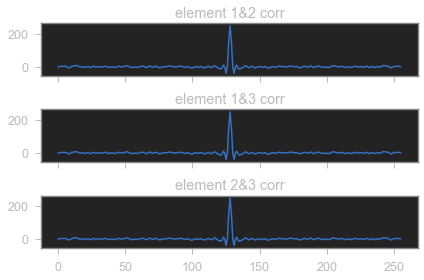

In [45]:
# Plotting the real part of the correlation
corr1REAL = np.real(np.array(corr[0])) # 1&2
corr2REAL = np.real(np.array(corr[1])) # 1&3
corr3REAL = np.real(np.array(corr[2])) # 2&3

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_corr1, ax_corr2, ax_corr3) = plt.subplots(3, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 0

# Element 1, no phase shift
ax_corr1.plot(corr1REAL[sample])
ax_corr1.set_title('element 1&2 corr')

# Element 2, phase shifted verion of element 1
ax_corr2.plot(corr2REAL[sample])
ax_corr2.set_title('element 1&3 corr')

# Element 2, phase shifted verion of element 1
ax_corr3.plot(corr3REAL[sample])
ax_corr3.set_title('element 2&3 corr')

fig.tight_layout()
fig.show()

<ipython-input-46-db25ddc7da30>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


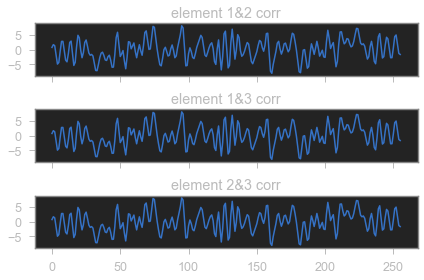

In [46]:
# Plotting the imag part of the correlation
corr1IMAG = np.imag(np.array(corr[0])) # 1&2
corr2IMAG = np.imag(np.array(corr[1])) # 1&3
corr3IMAG = np.imag(np.array(corr[2])) # 2&3

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_corr1, ax_corr2, ax_corr3) = plt.subplots(3, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 0

# Element 1, no phase shift
ax_corr1.plot(corr1IMAG[sample])
ax_corr1.set_title('element 1&2 corr')

# Element 2, phase shifted verion of element 1
ax_corr2.plot(corr2IMAG[sample])
ax_corr2.set_title('element 1&3 corr')

# Element 2, phase shifted verion of element 1
ax_corr3.plot(corr3IMAG[sample])
ax_corr3.set_title('element 2&3 corr')

fig.tight_layout()
fig.show()

# Complex to polar

In [13]:
# Concatinating the real and imag parts of the correlation
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=2)
print(complexCorr.shape)

(3, 100, 512)


In [40]:
# Converting to polar from complex
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr,np.zeros((num_elements,numberofSamples,N))),axis=-1)
print(polarCorr.shape)

for n in range(num_elements):
    for j in range(numberofSamples):
        for i in range(N):
            temp = abs(tempCorr[n][j][i])
            temp2 = cmath.phase(tempCorr[n][j][i])
            polarCorr[n][j][i] = float(temp)
            polarCorr[n][j][N+i] = temp2

print('--------------------')
print(polarCorr.shape)
print(polarCorr[0].shape)
print(polarCorr[0][1].shape)

(3, 100, 256)
(3, 100, 512)
--------------------
(3, 100, 512)
(100, 512)
(512,)


In [42]:
for i in range(256):
    print(np.real(polarCorr[0][1][i]))

0.8371498693060244
2.1313365025405115
3.242943845646054
3.5622671806389974
5.687748110621533
5.516964605478623
1.952257839247565
4.188125600455828
6.7617855056502325
2.5625263255507047
4.714771753124447
6.423786841259835
5.591308905709161
8.039845560343775
8.046566041189285
2.8425515083691804
5.55180113386192
4.350174183542143
1.759407617425312
5.177228271650739
5.656967146537229
0.40369265024315976
3.619288507640806
1.8894686447264608
5.508321695156088
3.392346001753205
3.8969716176103866
1.9186746342837064
3.32340013331968
2.460635864482775
2.4773661050627127
4.67786063663058
7.176086392886226
7.199201133689885
5.505689152252458
4.623633030347121
2.2732130384954115
2.206011068200863
3.8979836959886005
3.599395044090887
3.82777050617421
2.9928670546347402
4.668993548169457
4.275890530467896
6.309548442113986
6.9101500380509036
2.7193102674539027
4.049530064687349
5.869277726053802
2.5041295248328614
5.516970607741809
7.021429088263183
5.1488861830996235
3.8568683272771214
7.3628024091

In [44]:
for i in range(256,512):
    print(np.real(polarCorr[0][1][i]))

2.1160565640674207
0.9035208981352766
0.41134591472528304
-0.5432381597708059
-1.055021651773723
-0.9198698875109099
-0.311484332638369
2.4206636851538024
2.717132884940519
-3.0236540384815416
-0.8698387285191103
-0.708079504354443
-0.2436976136794228
0.3058430605080555
0.36472617939801083
-0.4674250347688049
-1.7988137925622056
-1.5101481339567056
0.5298041745841651
1.9347368903447824
2.3560479365284044
-2.770337024009272
-0.8799852115544733
-2.559545245879393
2.6863573467739092
1.8644605019056082
0.2964938041816772
-0.6567467847658357
-2.516726474789405
-2.4020215246015315
-1.0924405974709086
-1.397682284914457
-1.7184836308227944
-1.6401469466501615
-1.1716029809498596
-0.6329032702397367
-0.5721380995393698
-2.722922717004396
-2.6102053395009164
-1.7667689719035897
-1.3319695387826003
-2.1921002344570373
-2.717014925180439
-2.120146629907521
-1.2678282954401228
-1.0410851816432467
-0.7274212623227062
1.551305514227563
1.5973234571831971
0.7474010718811618
-0.4450615867329582
-0.212